# Revil-Kaseya - Detection & Threat Hunting Notebook

* This Data is from a live Revil-Ransomware Sample that was shipped with Agent.exe for Kaseya-Supply Chain attack.
* The sample was Detonated-studied-reversed in a contained environment to study it.
* The Whole analytics is attributed towards emulation based Threat Hunting Technique.
* The Aim is to learn and Provide analytics for security Operations folks/Hunts to quickly adapt and test in their environment for the Malware
* The companion Blog is Hosted at : https://sakshamtushar.gitbook.io/threat-hunting-on-the-rocks/threat-research-and-analytics/revil-kaseya-supply-chain-attack
* if you're using or referring this notebook any-where, it would be kind of you if you attribute and mention about the author of the Notebook. 
* if you see an error, need support, have additional Queries reach our to me over linkedin,My details are at : https://sakshamtushar.gitbook.io/threat-hunting-on-the-rocks/


**List of hunts are as Below :**
* 1.1 - Suspicious File-Write Operations(Unstructured)
* 1.2 - MsMpEng.exe Binary/  Mpsvc.dll dropped in Temporary Location (Structured)
* 1.3 - DLL Side-Loading : DLL library Loaded from a  temporary Location(Unstructured)
* 1.4 - Known RegistryKey Value Modification(Structured) 
* 1.5 - Abnormally High Disk Write Operation - Data Encryption(Unstructured) 
* 1.6 - Un-usual Child-Parent Process Relationship(unstructured)

Structred Hunts have highest convertability to Detections, You can Turn them into high fidelity detections for the respective Case study

### Importing Libraries

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.caseSensitive", "true")
from elasticsearch import Elasticsearch
from elasticsearch import RequestsHttpConnection
from elasticsearch_dsl import Search
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth',-1)

### Initialize Elasticsearch Client

In [3]:
#es = Elasticsearch(['https://192.168.29.20:9200'])
es2 = Elasticsearch(['https://192.168.29.248:9200'], connection_class=RequestsHttpConnection, http_auth=('elastic', 'y4M0SXLypw4dYupJ8qxJ'), use_ssl=True, verify_certs=False)
searchContext = Search(using=es2, index='logs-endpoint.events*', doc_type='doc')

### Attack Surface Fabrication
#### Writing a Function to Query Elasticsearch and return us a dataset to work on

In [4]:
def queryes(query) :
    print(query)
    s = searchContext.query('query_string', query=query).filter('range' ,  **{'@timestamp': {'gte': 20211220 , 'lt': 20211222, 'format' : 'basic_date'}})
    response = s.execute()
    if response.success():
        df = pd.json_normalize((d.to_dict() for d in s.scan()))
        sdf=spark.createDataFrame(df.astype(str))
        clean_df = sdf.toDF(*(c.replace('.', '_') for c in sdf.columns))
        clean_df = clean_df.toDF(*(c.replace('@', '') for c in clean_df.columns))
        return clean_df
    else :
        print("Es query Failed")

In [5]:
# Gathering File Write Operations
dataset= queryes("event.category:file AND event.action:creation")
dataset.createOrReplaceTempView('dataset')

event.category:file AND event.action:creation


## Unstructured Hunt :  Looking for anomalous File Write Operations in Temporary File Directory
----------------------------------

In [6]:
df1=spark.sql('select count(*) as count,file_name,process_name,process_parent_pid from dataset where (file_name like "%exe%" OR file_name like "%dll%") GROUP BY file_name,process_name,process_parent_pid order by process_name desc;')
df1.show(1000,truncate=False)

+-----+-------------------------------------------+----------------+------------------+
|count|file_name                                  |process_name    |process_parent_pid|
+-----+-------------------------------------------+----------------+------------------+
|1    |widevinecdm.dll                            |msedge.exe      |4496              |
|1    |widevinecdm.dll.sig                        |msedge.exe      |4496              |
|1    |Microsoft.CognitiveServices.Speech.core.dll|msedge.exe      |4496              |
|1    |MsMpEng.exe                                |Kaseya_agent.exe|4496              |
|1    |mpsvc.dll                                  |Kaseya_agent.exe|4496              |
+-----+-------------------------------------------+----------------+------------------+



#### Suspicious Observation :  MsMpEng.exe Binary in temporary Location is Suspicious at first glance, what is MS-defender Binary doing in temporary location.Also Agent.exe does'nt seem to be a lolbin and seems to be a 3rd party binary.

In [7]:
df1=spark.sql('select Distinct process_name,process_parent_pid from dataset where (file_name like "%exe%" OR file_name like "%dll%");')
df1.show(1000,truncate=False)

+----------------+------------------+
|process_name    |process_parent_pid|
+----------------+------------------+
|Kaseya_agent.exe|4496              |
|msedge.exe      |4496              |
+----------------+------------------+



##### Interestingly we have two entries where file write was performed by Agent.exe, Let's Pull Process Data to Correlate!!

In [8]:
#pulling Process Dataset
proc_dataset=queryes("event.category:process")
proc_dataset.createOrReplaceTempView('processes')

event.category:process


##### Process Hashes of Processess Writing in the Directory : 

In [9]:
spark.sql("select distinct p.process_name,p.process_code_signature_status,p.process_hash_sha256,d.file_name from processes p, dataset d where p.process_pid = d.process_pid AND (d.file_name like '%exe%' OR d.file_name like '%dll%') order by p.process_name").show(1000,truncate=False)

+----------------+-----------------------------+----------------------------------------------------------------+-------------------------------------------+
|process_name    |process_code_signature_status|process_hash_sha256                                             |file_name                                  |
+----------------+-----------------------------+----------------------------------------------------------------+-------------------------------------------+
|Kaseya_agent.exe|trusted                      |d55f983c994caa160ec63a59f6b4250fe67fb3e8c43a388aec60a4a6978e9f1e|MsMpEng.exe                                |
|Kaseya_agent.exe|trusted                      |d55f983c994caa160ec63a59f6b4250fe67fb3e8c43a388aec60a4a6978e9f1e|mpsvc.dll                                  |
|msedge.exe      |trusted                      |18a839142796d6e4d0fa44f5a75e0cd79cc5c1a5fde39b7cc00faec50a899b6d|Microsoft.CognitiveServices.Speech.core.dll|
|msedge.exe      |trusted                      |18a8

#### Suspicious Observation: Agent.exe Doesn't seem to have very good Reputation !!!!
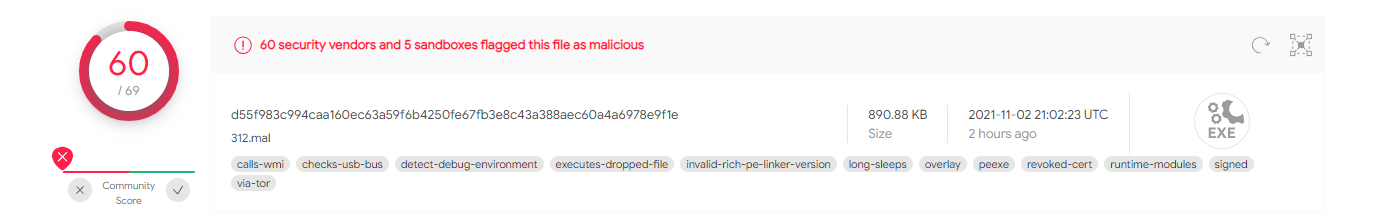

#### let's gather Hashes& CommandLines of these Process Executables Create a table of Parent Process, Child Process and Files Written on Disk 

In [10]:
spark.sql("select   distinct d.process_name as writing_process, d.file_name as dropped_file, p.process_parent_name as Parent_process,p.process_command_line as writing_process_cmdLine,\
          p.process_code_signature_status,p.process_hash_sha256 \
          from processes p, dataset d where p.process_name = d.process_name and d.process_name='Kaseya_agent.exe'").show(200,truncate=False, vertical=True)

-RECORD 0-----------------------------------------------------------------------------------------
 writing_process               | Kaseya_agent.exe                                                 
 dropped_file                  | mpsvc.dll                                                        
 Parent_process                | explorer.exe                                                     
 writing_process_cmdLine       | "C:\Users\IEUser\Downloads\Kaseya_agent.exe"                     
 process_code_signature_status | trusted                                                          
 process_hash_sha256           | d55f983c994caa160ec63a59f6b4250fe67fb3e8c43a388aec60a4a6978e9f1e 
-RECORD 1-----------------------------------------------------------------------------------------
 writing_process               | Kaseya_agent.exe                                                 
 dropped_file                  | MsMpEng.exe                                                      
 Parent_pr

#### Now there are enough peices of information to Chase this Rabbit Hole for Suspicious Agent.exe :
* Msmgeng.exe written in temporary Location is Suspicious(Reason : What's a defender binary doing in temporary Location)
* A non Windows Process write Defender binary (Reason : the operation is suspicious cause the process tree is like : Explorer.exe -> Agent.exe -> Drop MsMpEng.exe) 
* A DLL file is also dropped by same process (Reason : Could be Masquerade, Could be Tampered DLL, Could be payload embedded in DLL Entry Point,Could be DLL Search order hijacking attacks , DLL Side-loading attacks, lots of possibilities)

#### A sub-hypothesis could be devised at this point to chase this path : Malware Dropped by non-legitimate process and proceed with Investigation, Sample Acquisition, Reverse Engineering, Malware Sandboxing, Detonation.

## Structured Hunt :  MsMpEng.exe & mpsvc.dll Binary dropped in Temporary Location
----------------------------------

Note : I won't suggest this structured Hunt, although this could be converted into a detection in your EDR, This Hunt falls too low on the Pyramid of Pain and although there is a behaviour exhibhited but is not really a behavioural search hence an attacker could easily pass this Hunt/Detection Technique

In [11]:
spark.sql("select distinct p.process_parent_name as Parent_process,p.process_command_line as writing_process_cmdLine,d.process_name as writing_process,p.process_code_signature_status,p.process_hash_sha256,d.file_name from processes p, dataset d where p.process_name = d.process_name and (d.file_name='MsMpEng.exe' OR d.file_name='mpsvc.dll')").show(200,truncate=False,vertical=True)

-RECORD 0-----------------------------------------------------------------------------------------
 Parent_process                | explorer.exe                                                     
 writing_process_cmdLine       | "C:\Users\IEUser\Downloads\Kaseya_agent.exe"                     
 writing_process               | Kaseya_agent.exe                                                 
 process_code_signature_status | trusted                                                          
 process_hash_sha256           | d55f983c994caa160ec63a59f6b4250fe67fb3e8c43a388aec60a4a6978e9f1e 
 file_name                     | mpsvc.dll                                                        
-RECORD 1-----------------------------------------------------------------------------------------
 Parent_process                | explorer.exe                                                     
 writing_process_cmdLine       | "C:\Users\IEUser\Downloads\Kaseya_agent.exe"                     
 writing_p

## UnStructured Hunt :  DLL library Loaded from a  temporary Location
----------------------------------

In [12]:
#Pulling DLL Loading dataset from Elastic
dll_dataset=queryes("event.category :library")
dll_dataset.createOrReplaceTempView('lib_dataset')

event.category :library


In [13]:
spark.sql("select distinct lib_dataset.process_name as Process_name, lib_dataset.process_executable as Process_path, dll_name as DLL_loaded , dll_path from lib_dataset where lib_dataset.dll_path like '%Temp%'").show(truncate=False)

+------------+----------------------------------------------+----------+--------------------------------------------+
|Process_name|Process_path                                  |DLL_loaded|dll_path                                    |
+------------+----------------------------------------------+----------+--------------------------------------------+
|MsMpEng.exe |C:\Users\IEUser\AppData\Local\Temp\MsMpEng.exe|mpsvc.dll |C:\Users\IEUser\AppData\Local\Temp\mpsvc.dll|
+------------+----------------------------------------------+----------+--------------------------------------------+



#### Dropped MsMpEng.exe is performing DLL SideLoading of Dropped DLL mpsvc.dll from temporary location.

## Structured Hunt :  Known RegistryKey  Value Modification
----------------------------------

In [14]:
#Pulling DLL Loading dataset from Elastic
registry_dataset=queryes("event.category : registry and event.action : modification")
registry_dataset.createOrReplaceTempView('reg_dataset')

event.category : registry and event.action : modification


In [15]:
spark.sql("select registry_path,registry_value,process_name from reg_dataset where registry_path like '%Black%'").show(truncate=False)

+------------------------------------------------------------------------------------------+--------------+------------+
|registry_path                                                                             |registry_value|process_name|
+------------------------------------------------------------------------------------------+--------------+------------+
|HKEY_USERS\S-1-5-21-321011808-3761883066-353627080-1000\Software\BlackLivesMatter\Ed7     |Ed7           |MsMpEng.exe |
|HKEY_USERS\S-1-5-21-321011808-3761883066-353627080-1000\Software\BlackLivesMatter\QIeQ    |QIeQ          |MsMpEng.exe |
|HKEY_USERS\S-1-5-21-321011808-3761883066-353627080-1000\Software\BlackLivesMatter\96Ia6   |96Ia6         |MsMpEng.exe |
|HKEY_USERS\S-1-5-21-321011808-3761883066-353627080-1000\Software\BlackLivesMatter\Ucr1RB  |Ucr1RB        |MsMpEng.exe |
|HKEY_USERS\S-1-5-21-321011808-3761883066-353627080-1000\Software\BlackLivesMatter\wJWsTYE |wJWsTYE       |MsMpEng.exe |
|HKEY_USERS\S-1-5-21-321011808-3

## Unstructured Hunt : Abnormally High Disk Write Operation - Data Encryption 
----------------------------------

In [17]:
file_dataset=queryes("event.dataset: endpoint.events.file")
file_dataset.createOrReplaceTempView('file_dataset')

event.dataset: endpoint.events.file


In [18]:
spark.sql("select process_name,count(process_name) as count from file_dataset GROUP BY process_name ORDER by count Desc").show(truncate=False)

+-----------------+-----+
|process_name     |count|
+-----------------+-----+
|msedge.exe       |1866 |
|System           |788  |
|MsMpEng.exe      |292  |
|svchost.exe      |230  |
|chrome.exe       |151  |
|provtool.exe     |132  |
|SearchUI.exe     |62   |
|OneDrive.exe     |11   |
|explorer.exe     |10   |
|FileCoAuth.exe   |6    |
|osqueryd.exe     |6    |
|Sysmon64.exe     |6    |
|mmc.exe          |6    |
|smartscreen.exe  |4    |
|SearchIndexer.exe|2    |
|lsass.exe        |2    |
|taskhostw.exe    |2    |
|ruby.exe         |2    |
|Kaseya_agent.exe |2    |
|metricbeat.exe   |1    |
+-----------------+-----+
only showing top 20 rows



In [19]:
df_fileset=spark.sql("select process_name,count(process_name) as count from file_dataset GROUP BY process_name ORDER by count Desc").toPandas()

In [20]:
df_fileset

,process_name,count
0,msedge.exe,1866
1,System,788
2,MsMpEng.exe,292
3,svchost.exe,230
4,chrome.exe,151
5,provtool.exe,132
6,SearchUI.exe,62
7,OneDrive.exe,11
8,explorer.exe,10
9,mmc.exe,6


In [21]:
df_fileset['count'].describe()

count    23.000000  
mean     155.826087 
std      411.596520 
min      1.000000   
25%      2.000000   
50%      6.000000   
75%      97.000000  
max      1866.000000
Name: count, dtype: float64

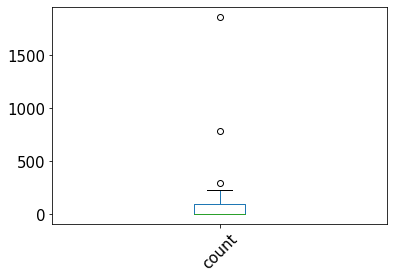

In [22]:
boxplot = df_fileset.boxplot(column=['count'],grid=False, rot=45, fontsize=15)

#### Treat all data points above 75% mark as points of investigation (ignoring below 25% as we arelooking for abonormally high values)

## Unstructured Hunt : Illegal Child-parent Process Relationships
----------------------------------

In [43]:
spark.sql("select distinct(process_name),process_parent_name from processes Order by process_parent_name").show(2000, False)

+------------------------------------------------------------------+-----------------------+
|process_name                                                      |process_parent_name    |
+------------------------------------------------------------------+-----------------------+
|MsMpEng.exe                                                       |Kaseya_agent.exe       |
|MicrosoftEdgeUpdate.exe                                           |MicrosoftEdgeUpdate.exe|
|conhost.exe                                                       |MpCmdRun.exe           |
|MpCmdRun.exe                                                      |MsMpEng.exe            |
|netsh.exe                                                         |MsMpEng.exe            |
|mmc.exe                                                           |RuntimeBroker.exe      |
|SearchFilterHost.exe                                              |SearchIndexer.exe      |
|SearchProtocolHost.exe                                            |Se

#### Interesting Entries & potential Point of Investigations observed from above table are : 
 
Kaseya_agent.exe   --> MsMpEng.exe     
MsMpEng.exe --> MpCmdRun.exe  
MsMpEng.exe --> netsh.exe                                                     
cmd.exe --> certutil.exe                
msedge.exe --> setup.exe                                                      


In [52]:
spark.sql("select process_name,process_command_line from processes where process_name in ('netsh.exe','certutil.exe','MsMpEng.exe','setup.exe','MpCmdRun.exe')").show(2000, False)

+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|process_name|process_command_line                                                                                                                                                                                     |
+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|MpCmdRun.exe|"C:\Program Files\Windows Defender\mpcmdrun.exe" -wddisable                                                                                                                                              |
|MpCmdRun.exe|"C:\ProgramData\Microsoft\Windows Defender\platform\4.18.2111.5-0\MpCmdRun.exe" GetDeviceTicket -AccessKey 88826F85-53

* **MpCmdRun.exe -> Interesting event where MpCmdRun.exe is trying to disable the Service.**
* **Netsh.exe -> Interesting attempt of turning on Network Discovery using netsh.exe**
* Certutil.exe ->These are my executions where i was trying to match hash of a file with the sample i acquired, THese can be Ignored. 
* Setup.exe -> This is Microsoft edge Installation. for when my windows OS updated.Can be Ignored.
* **MsMpEng.exe ->Execution from Temporary location, Execution of v4.18.2111 from ProgramData**

## netsh.exe execution clearly shows Modification of system configuration for lateral Movement hence could be converted into a detection/Structred Hunt.

In [55]:
 spark.sql("select process_name,process_command_line from processes where process_name ='netsh.exe' and process_command_line='netsh advfirewall firewall set rule group=\"Network Discovery\" new enable=Yes'").show(2000, False)

+------------+----------------------------------------------------------------------------+
|process_name|process_command_line                                                        |
+------------+----------------------------------------------------------------------------+
|netsh.exe   |netsh advfirewall firewall set rule group="Network Discovery" new enable=Yes|
|netsh.exe   |netsh advfirewall firewall set rule group="Network Discovery" new enable=Yes|
+------------+----------------------------------------------------------------------------+



# DLL Side-loading via MsMpEng.exe - Details 

we saw that the MsMpEng.exe binary was dropped on the machine along with mpsvc.dll which were actually used for malicious intention.
We also do understand that mpsvc.dll was sideloaded into MsMpEng.exe, but there are a few questions that we need to find answers for to understand what happened.

## Why drop MsMpEng.exe, when it is already present on the Machine a Lolbin ???

In [65]:
#grabbing all the processes that correlated to MsMpEng.exe on the Endpoint 
spark.sql("select  distinct(process_hash_sha256),process_name,process_command_line from processes where process_name like '%MsMpEng.exe%'").show(100,truncate = False, vertical = True)

-RECORD 0----------------------------------------------------------------------------------------------
 process_hash_sha256  | a7c1fe30930d982d69cc263076142edb451ae896b67efbca347b54e064c93bb9               
 process_name         | MsMpEng.exe                                                                    
 process_command_line | "C:\ProgramData\Microsoft\Windows Defender\platform\4.18.2111.5-0\MsMpEng.exe" 
-RECORD 1----------------------------------------------------------------------------------------------
 process_hash_sha256  | 33bc14d231a4afaa18f06513766d5f69d8b88f1e697cd127d24fb4b72ad44c7a               
 process_name         | MsMpEng.exe                                                                    
 process_command_line | "C:\Users\IEUser\AppData\Local\Temp\MsMpEng.exe"                               



As you can observe there are two hashes for MsMpEng.exe, One is of the original Binary and another one of the Dropped Binary.
Correlating data from VirusTotal : 

* 33bc14d231a4afaa18f06513766d5f69d8b88f1e697cd127d24fb4b72ad44c7a(Dropped Binary) hash is also bening and is a signed legitimate binary

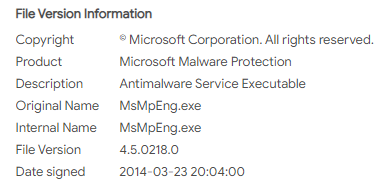

* a7c1fe30930d982d69cc263076142edb451ae896b67efbca347b54e064c93bb9(Original Binary) is also legitimate and signed binary, except for the fact that this binary is newer (V4.18)

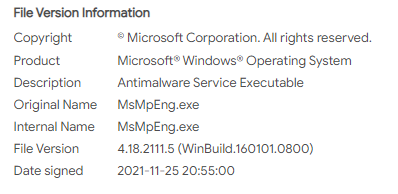

* The older MsMpEng.exe was susceptible to DLL Side loading Technique and hence was perfect for targetting and attacking